# Utility measures for synthetic data before and after the anonymization algorithm is applied.

In [110]:
import pandas as pd
import numpy as np
import itertools

from pointpats import PointPattern
from pointpats.distance_statistics import L

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from pyproj import Proj
from geopy.geocoders import Nominatim

In [111]:
train_data = pd.read_csv("Data/train_dataset.csv")

In [112]:
holdout_data = [pd.read_csv("Data/holdout_" + str(i) + ".csv") for i in range(20)]

In [113]:
# sXs_mnl_ks = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_ks_" + str(i) + ".csv") for i in range(20)]
sXs_mnl_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
sXs_mnl_inf_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_inf_pmse_" + str(i) + ".csv") for i in range(20)]

In [115]:
# sXs_cart_ks = [pd.read_csv("Data/synthetic_datasets/cart_logistic_ks_" + str(i) + ".csv") for i in range(20)]
# sXs_cart_pmse = [pd.read_csv("Data/synthetic_datasets/cart_logistic_pmse_" + str(i) + ".csv") for i in range(20)]

# sXs_cart_mb_ks = [pd.read_csv("Data/synthetic_datasets/cart_mb_logistic_ks_" + str(i) + ".csv") for i in range(20)]
sXs_cart_mb_pmse = [pd.read_csv("Data/synthetic_datasets/cart_mb_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
sXs_cart_mb_inf_pmse = [pd.read_csv("Data/synthetic_datasets/cart_mb_inf_logistic_pmse_" + str(i) + ".csv") for i in range(20)]

In [116]:
sXs_mostly = [pd.read_csv("Data/synthetic_datasets/mostly_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [117]:
# def cart_pmse_ratio(original_data, synthetic_data_sets):
    
#     null_pmse_list = []
    
#     inds = np.arange(len(synthetic_data_sets))
    
#     combo_list = list(itertools.combinations(inds, 2))
    
#     for combo in combo_list:
    
#         s1 = synthetic_data_sets[combo[0]]
#         s2 = synthetic_data_sets[combo[1]]
    
#         N_orig = s1.shape[0]
#         N_synth = s2.shape[0]
    
#         c = N_synth/(N_synth+N_orig)
    
#         full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
#         full_X = preprocessing.StandardScaler().fit_transform(full_X)

#         y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#         cart = DecisionTreeClassifier(min_samples_split=20,
#                                       min_samples_leaf=int(np.round(20/3)),
#                                       ccp_alpha=0.0001,
#                                       max_depth=30)
    
#         cart.fit(X=full_X, y=y)
    
#         probs = cart.predict_proba(full_X)
    
#         pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
#         null_pmse_list.append(pMSE)
    
#     pmse_list = []
    
#     for s in synthetic_data_sets:
    
#         N_orig = original_data.shape[0]
#         N_synth = s.shape[0]
    
#         c = N_synth/(N_synth+N_orig)
    
#         full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
#         full_X = preprocessing.StandardScaler().fit_transform(full_X)

#         y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#         cart = DecisionTreeClassifier(min_samples_split=20,
#                                       min_samples_leaf=int(np.round(20/3)),
#                                       ccp_alpha=0.0001,
#                                       max_depth=30)
    
#         cart.fit(X=full_X, y=y)
    
#         probs = cart.predict_proba(full_X)
    
#         pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
#         pmse_list.append(pMSE)
        
#     return np.array(pmse_list)/np.mean(null_pmse_list), null_pmse_list

In [118]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
#     full_X["age"] = full_X["age"].astype('category')
    
#     age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
#     age_dummies.columns = [str(x) for x in age_dummies.columns]
    
#     full_X = full_X.drop("age", axis=1)
    
#     full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
#     full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

In [119]:
np.mean([pmse_ratio(train_data, x) for x in holdout_data])

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9353534575308771

In [120]:
# ratios_mnl_ks = [pmse_ratio(train_data, Y) for Y in sXs_mnl_ks]
ratios_mnl_pmse = [pmse_ratio(train_data, Y) for Y in sXs_mnl_pmse]
ratios_mnl_inf_pmse = [pmse_ratio(train_data, Y) for Y in sXs_mnl_inf_pmse]
# ratios, null_ratios = cart_pmse_ratio(train_data, sXs_mnl)
# print(np.mean(ratios_mnl_ks))
print(np.mean(ratios_mnl_pmse))
print(np.mean(ratios_mnl_inf_pmse))

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9447361230820744
1.9026570751079823


In [121]:
# ratios_cart_ks = [pmse_ratio(train_data, Y) for Y in sXs_cart_ks]
# ratios_cart_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_pmse]

# ratios_cart_mb_ks = [pmse_ratio(train_data, Y) for Y in sXs_cart_mb_ks]
ratios_cart_mb_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_mb_pmse]
ratios_cart_mb_inf_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_mb_inf_pmse]
# ratios, null_ratios = cart_pmse_ratio(train_data, sXs_mnl)
# print(np.mean(ratios_cart_ks))
# print(np.mean(ratios_cart_pmse))

# print(np.mean(ratios_cart_mb_ks))
print(np.mean(ratios_cart_mb_pmse))
print(np.mean(ratios_cart_mb_inf_pmse))

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

1.0498602402351522
1.9341599608596496


In [122]:
ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
# mostly_ratios, null_mostly_ratios = cart_pmse_ratio(train_data, sXs_mostly)
np.mean(ratios_mostly)

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

1.250419916712535

***

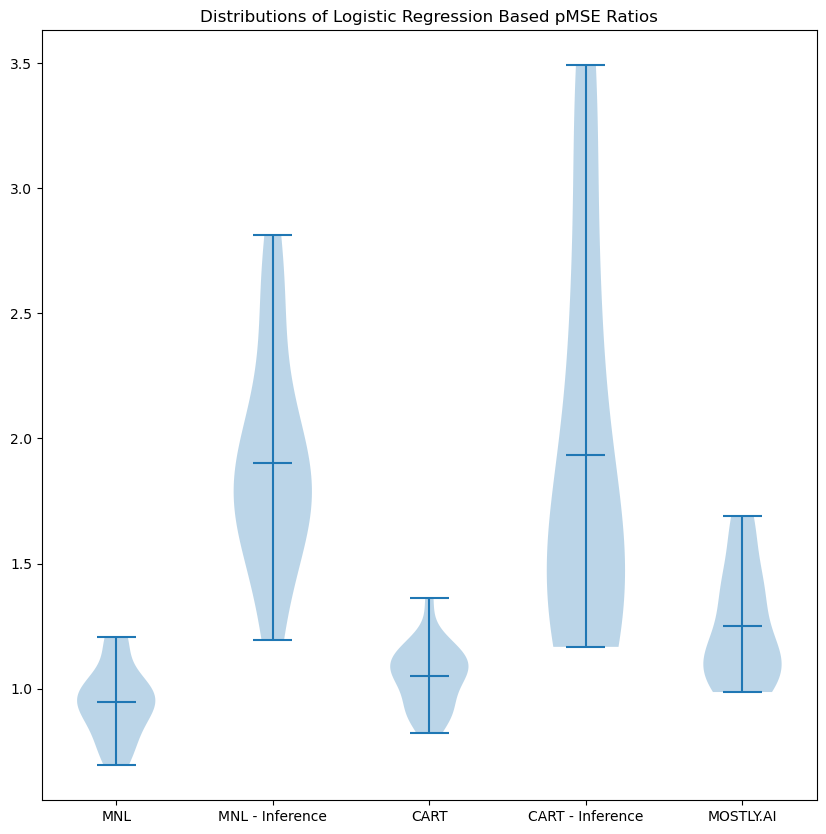

In [124]:
# Combine data
plot_data = list([ratios_mnl_pmse, ratios_mnl_inf_pmse, ratios_cart_mb_pmse, ratios_cart_mb_inf_pmse, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

## Utility Measure 2 - K and L Functions

Calculate L function for original and synthetic datasets and plot.

In [125]:
# L function value for original data
l_orig = L(PointPattern(train_data.loc[:,['latitude', 'longitude']])).l

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [127]:
# L function values for synthetic data
# l_mnl_inf = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl_inf]
l_mnl_inf_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl_inf_pmse]
l_mnl_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [128]:
# L function values for anonymized synthetic data
# l_cart_ks = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_ks]
# l_cart_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_pmse]

# L function values for anonymized synthetic data
# l_cart_mb_ks = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_mb_ks]
l_cart_mb_inf_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_mb_inf_pmse]
l_cart_mb_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_mb_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [27]:
# L function values for MOSTLY.AI synthetic data
l_mostly = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mostly]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [129]:
# pos_sXs_mnl_ks = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl_ks]
pos_sXs_mnl_inf_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl_inf_pmse]
pos_sXs_mnl_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl_pmse]

In [130]:
# pos_sXs_cart_ks = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_ks]
# pos_sXs_cart_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_pmse]

# pos_sXs_cart_mb_ks = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_mb_ks]
pos_sXs_cart_mb_inf_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_mb_inf_pmse]
pos_sXs_cart_mb_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_mb_pmse]

In [30]:
pos_sXs_mostly = [Y.loc[Y.state==1.0,:] for Y in sXs_mostly]

In [31]:
pos_l_orig = L(PointPattern(train_data.loc[train_data.state==1.0,["latitude", "longitude"]])).l

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [131]:
# pos_l_mnl_ks = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mnl_ks]
pos_l_mnl_inf_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mnl_inf_pmse]
pos_l_mnl_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mnl_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

In [132]:
# pos_l_cart_ks = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_ks]
# pos_l_cart_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_pmse]

# pos_l_cart_mb_ks = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_mb_ks]
pos_l_cart_mb_inf_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_mb_inf_pmse]
pos_l_cart_mb_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_mb_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

In [34]:
pos_l_mostly = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mostly]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

In [35]:
def L_plot(ax1, line_orig, line_synthetic, plot_title):
    
    # x values to plot
    x = np.arange(0, 1.2, 0.1)
    
    # average L function for synthetic data
    synthetic_mean = np.mean(line_synthetic, axis=0)

    # calculate 95% empirical confidence interval for L function value for synthetic data
    qs = np.quantile(line_synthetic, (0.025, 0.975), axis=0)
    
    ax1.plot(x, line_orig, label = 'Original')
    ax1.plot(x, synthetic_mean, label = 'Avg Synthetic')
    ax1.fill_between(x, qs[0,:], qs[1,:], alpha = 0.3)
    ax1.legend(loc = 'lower right')
    ax1.set_title(plot_title)
    ax1.set_xlabel('h')
    ax1.set_ylabel('L(h)')

L functions for all locations.

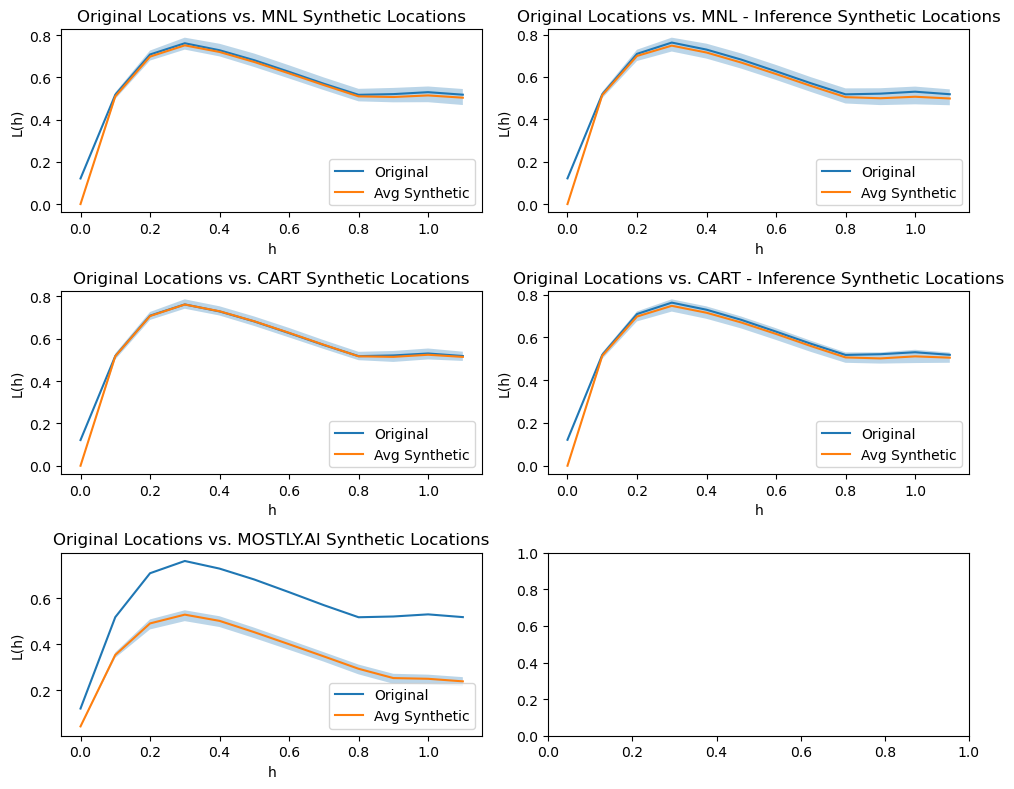

In [134]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))

# L_plot(ax[0,0], l_orig, l_mnl_ks, "Original Locations vs. MNL KS Synthetic Locations")
L_plot(ax[0,0], l_orig, l_mnl_pmse, "Original Locations vs. MNL Synthetic Locations")
L_plot(ax[0,1], l_orig, l_mnl_inf_pmse, "Original Locations vs. MNL - Inference Synthetic Locations")

# L_plot(ax[1,0], l_orig, l_cart_ks, "Original Locations vs. CART Synthetic Locations")
# L_plot(ax[1,1], l_orig, l_cart_pmse, "Original Locations vs. CART Synthetic Locations")

# L_plot(ax[2,0], l_orig, l_cart_mb_ks, "Original Locations vs. CART MB Synthetic Locations")
L_plot(ax[1,0], l_orig, l_cart_mb_pmse, "Original Locations vs. CART Synthetic Locations")
L_plot(ax[1,1], l_orig, l_cart_mb_inf_pmse, "Original Locations vs. CART - Inference Synthetic Locations")

L_plot(ax[2,0], l_orig, l_mostly, "Original Locations vs. MOSTLY.AI Synthetic Locations")

plt.tight_layout()

L functions for Positive Locations Only

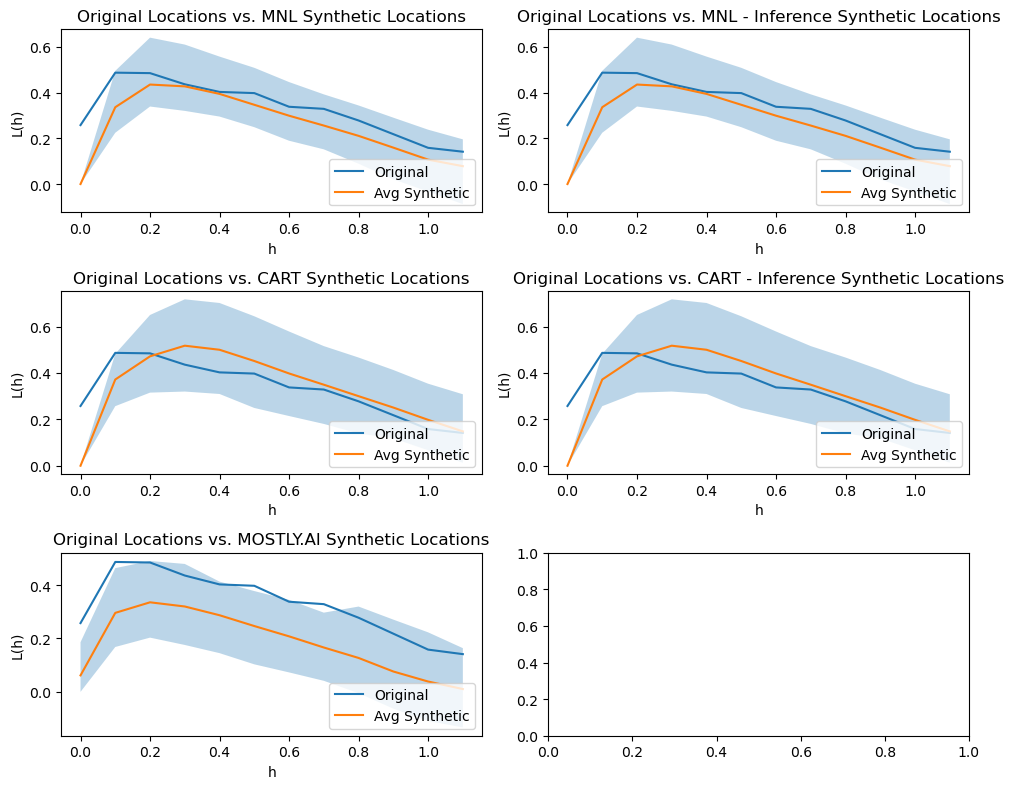

In [137]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))

# L_plot(ax[0,0], pos_l_orig, pos_l_mnl_ks, "Original Locations vs. MNL KS Synthetic Locations")
L_plot(ax[0,0], pos_l_orig, pos_l_mnl_pmse, "Original Locations vs. MNL Synthetic Locations")
L_plot(ax[0,1], pos_l_orig, pos_l_mnl_inf_pmse, "Original Locations vs. MNL - Inference Synthetic Locations")

# L_plot(ax[1,0], pos_l_orig, pos_l_cart_ks, "Original Locations vs. CART Synthetic Locations")
# L_plot(ax[1,1], pos_l_orig, pos_l_cart_pmse, "Original Locations vs. CART Synthetic Locations")

# L_plot(ax[2,0], pos_l_orig, pos_l_cart_mb_ks, "Original Locations vs. CART MB Synthetic Locations")
L_plot(ax[1,0], pos_l_orig, pos_l_cart_mb_pmse, "Original Locations vs. CART Synthetic Locations")
L_plot(ax[1,1], pos_l_orig, pos_l_cart_mb_inf_pmse, "Original Locations vs. CART - Inference Synthetic Locations")

L_plot(ax[2,0], pos_l_orig, pos_l_mostly, "Original Locations vs. MOSTLY.AI Synthetic Locations")

plt.tight_layout()

# Utility Measure 3: Visual Comparison of Locations

Visual comparison of location distributions.

In [38]:
def scatter_plot(ax1, location_data, plot_title, xlab, ylab):
    
    ax1.scatter(location_data.longitude, location_data.latitude)
    
    ax1.set_title(plot_title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)

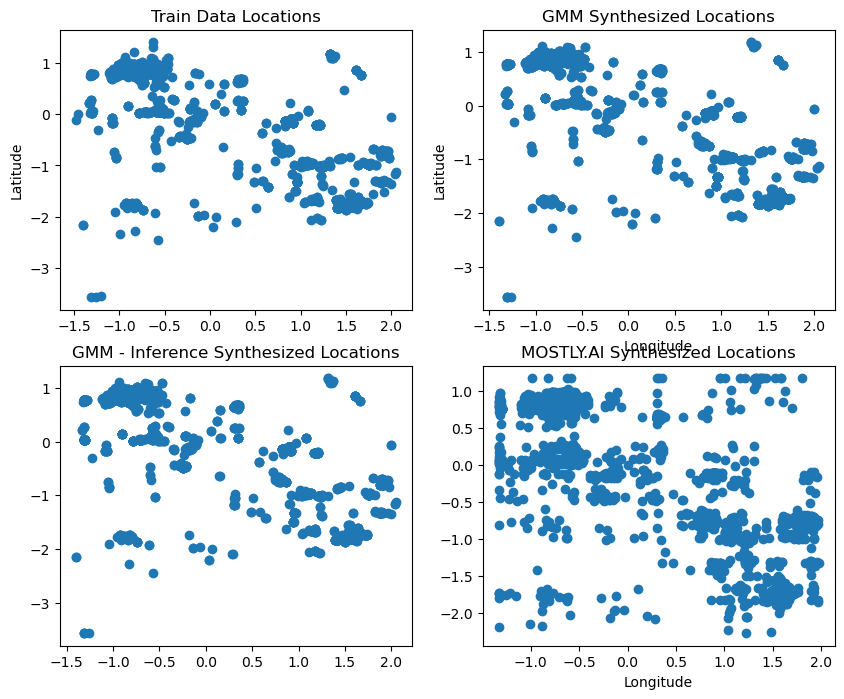

In [136]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data, "Train Data Locations", "", "Latitude")
scatter_plot(ax[0,1], sXs_mnl_pmse[0], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,0], sXs_mnl_inf_pmse[0], "GMM - Inference Synthesized Locations", "", "")
scatter_plot(ax[1,1], sXs_mostly[0], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

Look at plots of the points with positive mark values.

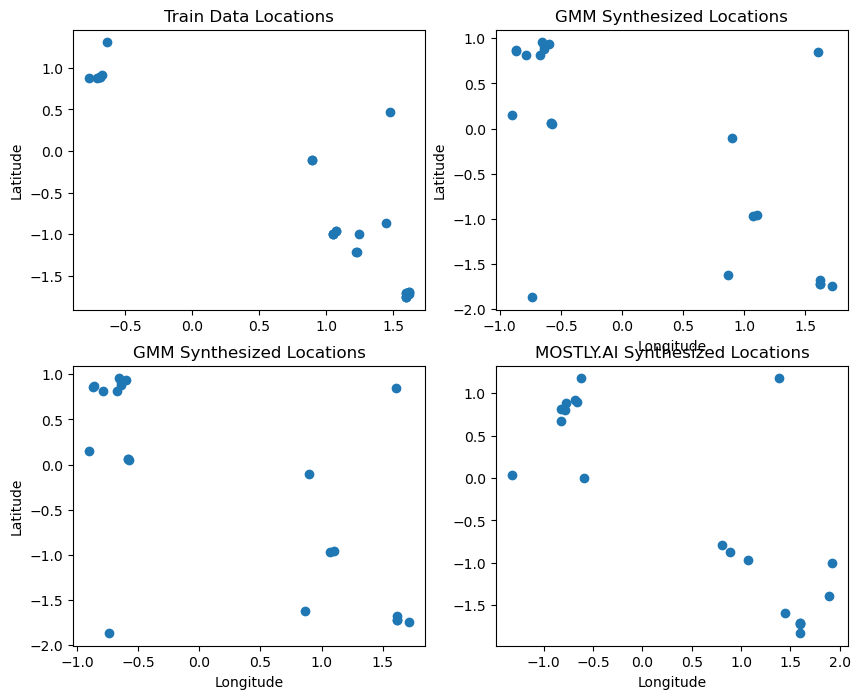

In [138]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data.loc[train_data.state==1.0,:], "Train Data Locations", "", "Latitude")
scatter_plot(ax[0,1], sXs_mnl_pmse[0].loc[sXs_mnl_pmse[0].state==1.0,:], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,0], sXs_mnl_inf_pmse[0].loc[sXs_mnl_inf_pmse[0].state==1.0,:], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0].loc[sXs_mostly[0].state==1.0,:], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

Analysis specific utility.

Use logistic regression to predict COVID-19 death based on latitude and longitude, age, and sex.

Compute the model for the original data.

In [139]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

In [140]:
def logit_param_getter(model_data):
    predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
    logit_results = state_logit.fit()
    return logit_results.params

In [141]:
# avg_mnl_ks_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_mnl_ks]), axis=0)

In [142]:
# avg_mnl_ks_params

In [143]:
# avg_mnl_pmse_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_mnl_pmse]), axis=0)

In [144]:
# avg_mnl_pmse_params

In [145]:
# avg_cart_ks_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_cart_ks]), axis=0)

In [146]:
# avg_cart_ks_params

In [147]:
# np.mean(sXs_cart_mb_ks[4].state)

In [148]:
# avg_cart_mb_ks_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_cart_mb_ks]), axis=0)

In [149]:
# avg_cart_pmse_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_cart_pmse]), axis=0)

In [150]:
# avg_cart_pmse_params

In [151]:
# avg_cart_mb_pmse_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_cart_mb_pmse]), axis=0)

In [152]:
# avg_cart_mb_pmse_params

In [153]:
# avg_mostly_params = np.mean(np.vstack([logit_param_getter(x) for x in sXs_mostly]), axis=0)

In [154]:
# avg_mostly_params

In [155]:
# logit_param_getter(train_data)

In [156]:
# predictors = train_data.loc[:, ["latitude", "longitude", "sex", "age"]]

In [157]:
# predictors = add_constant(predictors)

In [158]:
# state_logit = Logit(endog=train_data.loc[:, 'state'], exog=predictors)

In [159]:
# logit_results = state_logit.fit()

In [160]:
# logit_results.conf_int()

In [161]:
# logit_results.params

Calculate confidence interval overlap for a model applied to two data sets.

In [162]:
def logit_ci_getter(model_data):
    predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
    logit_results = state_logit.fit()
    return logit_results.conf_int().reset_index(drop=True)

In [163]:
# train_ci = logit_ci_getter(train_data)

In [164]:
# synth_ci = logit_ci_getter(sXs_mnl_ks[0])

In [165]:
# train_ci

In [166]:
# synth_ci

In [167]:
# IQ_list = []
# for i,row in train_ci.iterrows():
    
#     us = synth_ci.iloc[int(i),1]
#     ls = synth_ci.iloc[int(i),0]
#     uo = row[1]
#     lo = row[0]
    
#     ui = np.min([uo, us])
    
#     li = np.max([lo, ls])
    
#     IQ_list.append( 0.5 * ( (ui - li)/(uo - lo) + (ui - li)/(us - ls) ) )

In [168]:
def interval_overlap(train_dataset, synth_dataset):
    train_ci = logit_ci_getter(train_dataset)
    synth_ci = logit_ci_getter(synth_dataset)
    
    IQ_list = []
    for i,row in train_ci.iterrows():
    
        us = synth_ci.iloc[int(i),1]
        ls = synth_ci.iloc[int(i),0]
        uo = row[1]
        lo = row[0]
    
        ui = np.min([uo, us])
    
        li = np.max([lo, ls])
    
        IQ_list.append( 0.5 * ( np.max([(ui - li), 0])/(uo - lo) + np.max([(ui - li), 0])/(us - ls) ) )
        
    return IQ_list

In [169]:
# mnl_ks_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_ks])
mnl_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_pmse])
mnl_pmse_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_inf_pmse])
# cart_ks_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_ks])
# cart_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_pmse])
# cart_ks_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_ks])
cart_pmse_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_pmse])
cart_pmse_mb_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_inf_pmse])
mostly_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mostly])

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.026230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017857
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027260
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.025386
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.031200
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032067
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.031538
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017270
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024115
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.004625
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009788
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013443
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012229
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012244
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.

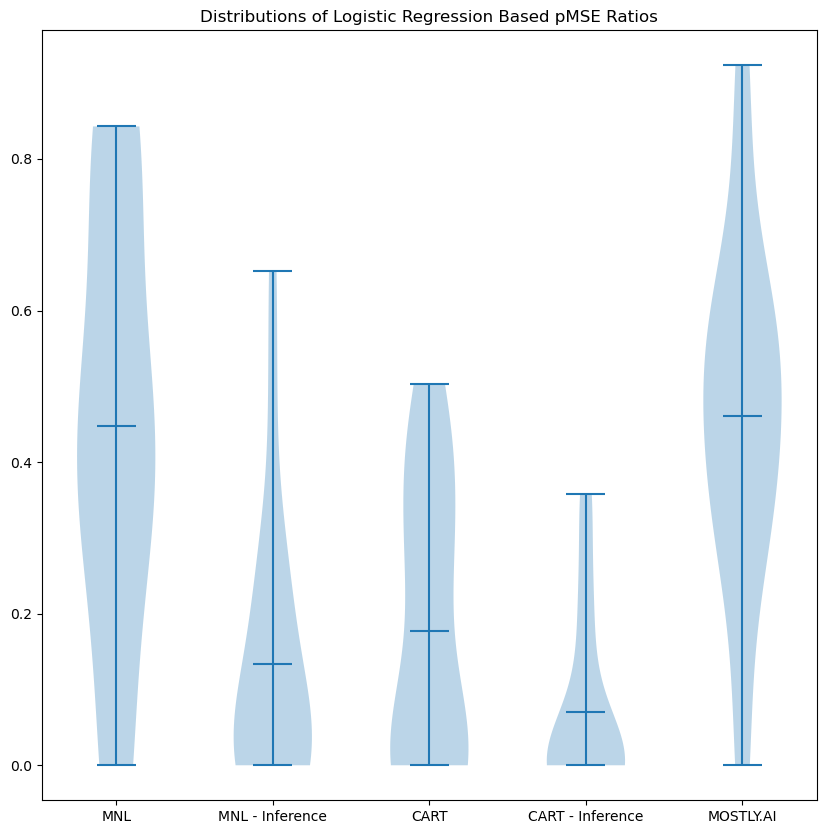

In [170]:
# Combine data
plot_data = list([mnl_pmse_intervals[:,0], mnl_pmse_inf_intervals[:,0], cart_pmse_mb_intervals[:,0], cart_pmse_mb_inf_intervals[:,0], mostly_intervals[:,0]])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

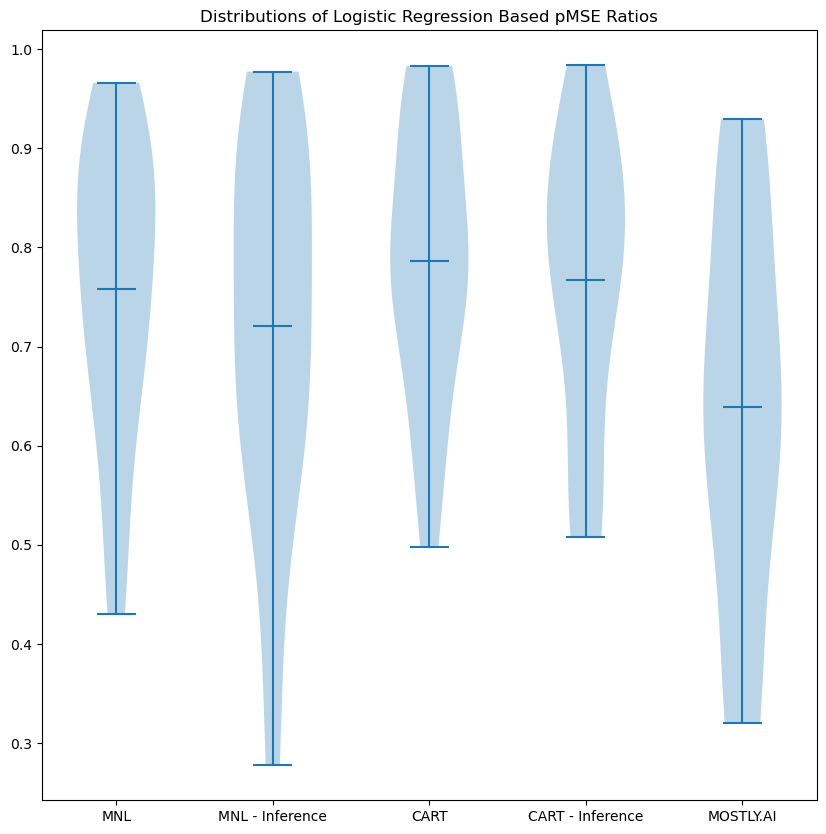

In [172]:
# Combine data
plot_data = list([mnl_pmse_intervals[:,1], mnl_pmse_inf_intervals[:,1], cart_pmse_mb_intervals[:,1], cart_pmse_mb_inf_intervals[:,1], mostly_intervals[:,1]])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

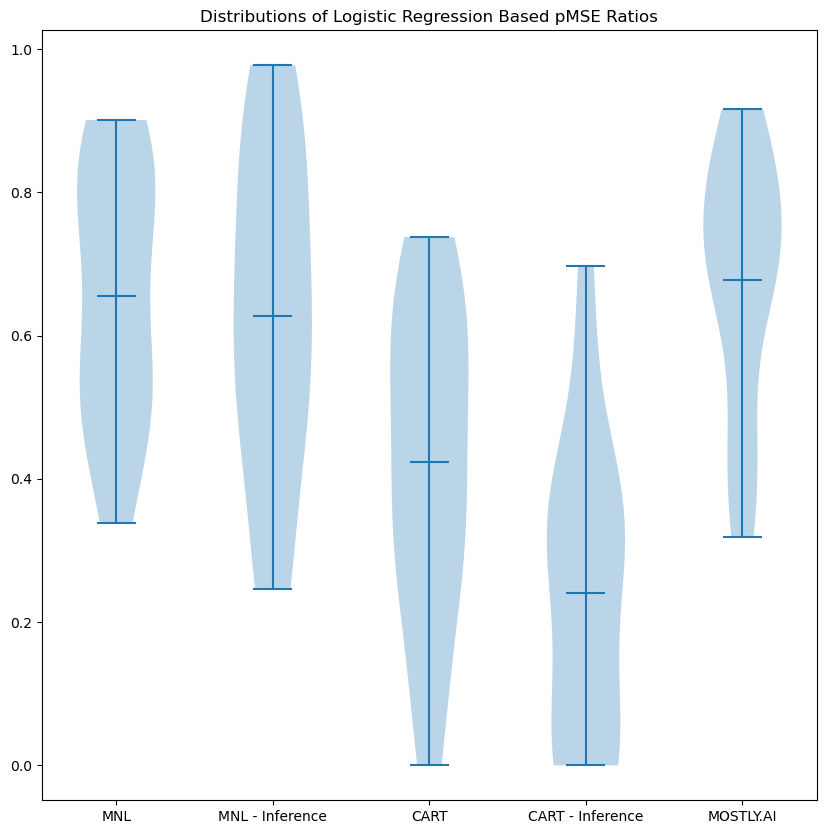

In [174]:
# Combine data
plot_data = list([mnl_pmse_intervals[:,2], mnl_pmse_inf_intervals[:,2], cart_pmse_mb_intervals[:,2], cart_pmse_mb_inf_intervals[:,2], mostly_intervals[:,2]])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

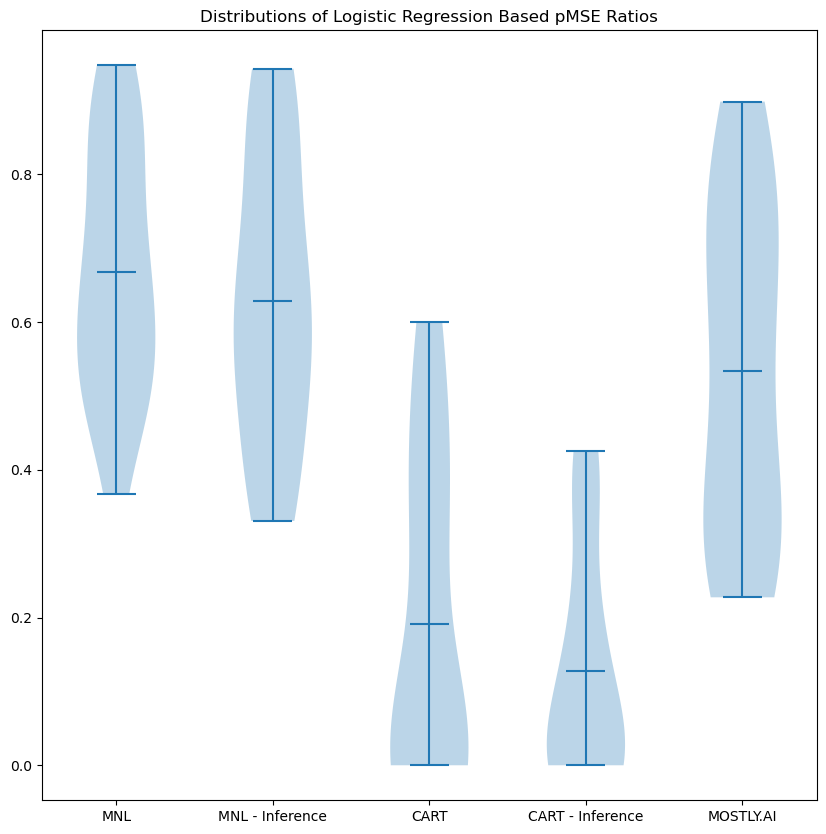

In [175]:
# Combine data
plot_data = list([mnl_pmse_intervals[:,3], mnl_pmse_inf_intervals[:,3], cart_pmse_mb_intervals[:,3], cart_pmse_mb_inf_intervals[:,3], mostly_intervals[:,3]])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

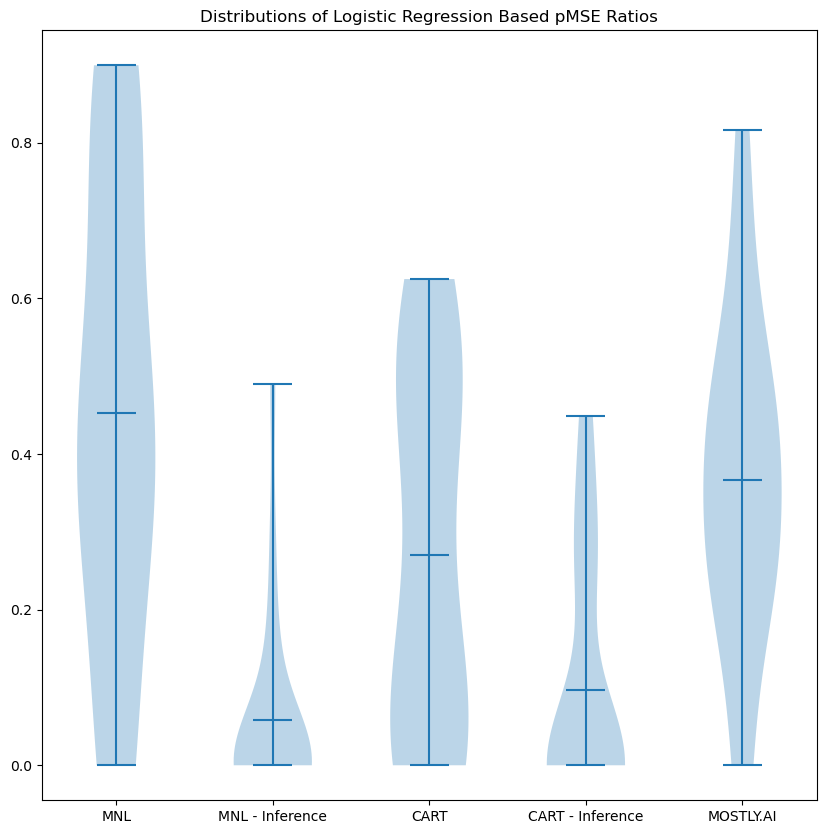

In [176]:
# Combine data
plot_data = list([mnl_pmse_intervals[:,4], mnl_pmse_inf_intervals[:,4], cart_pmse_mb_intervals[:,4], cart_pmse_mb_inf_intervals[:,4], mostly_intervals[:,4]])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()